# Stratified Propensity Score Matching Baseline 

### Propensity Score Model 
- Input: Same embeddings used in matching 
- Model: 
    - Logistic regression P(T|E) where T is binary treatment and E is the embeddings
    - Cross-fitting with cross validation for the regularizer 
- Ouput: Inference scores for each document that are the propensity scores 
    
### Causal Estimator: Stratified Propensity Score Matching  
- Input: Inference scores for each doc (above) 
- Approach: 5 strata, matching causal estimator 
- Output: Causal ATE 

In [1]:
# imports 
import numpy as np 
import pandas as pd
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.calibration import calibration_curve
from copy import deepcopy
import pprint
import ast
import statistics
import math
import time
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    average_precision_score,
)
import matplotlib.pyplot as plt

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create synthetic toy data just to make sure code runs 
# Raymond--you'll replace this with the real data 
nT1 = 100 #number of T=1 units
nT0 = 300 #number of T=0 units 
n_total = nT1 + nT0
T = np.array([1]*nT1 + [0]*nT0) #array with treatment values 
np.mean(T)

docids = np.arange(n_total)

embedding_dim = 50 #dimensionality of embeddings which is 768
E = np.random.randn(n_total, embedding_dim)

assert E.shape[0] == T.shape[0] == n_total == docids.shape[0]

In [3]:
import csv
embedding_path = '../../data/specter/df_embeddings.csv'
submission_path = '../../data/database/outputs/df_submission_rating.csv'
#embedding_path = '../data/specter/df_embeddings_abstract_only.csv'

df_embeddings = pd.read_csv(embedding_path)
df_embeddings = df_embeddings.T
df_embeddings.columns=df_embeddings.iloc[0]
df_embeddings = df_embeddings.iloc[1: , :]
#df_embeddings.to_csv('df_embeddings.csv', index = False)

tqdm.pandas()
def get_numpy (row):
  return ast.literal_eval(row.embedding)

df_embeddings['embedding'] = df_embeddings.progress_apply(lambda x: get_numpy(x), axis =1)

df_submissions = pd.read_csv(submission_path)
df_submission_labels = df_submissions[['id','title','conf_year','keywords','AVG_rating']]

df_embeddings = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year'].isin([2017,2018])], left_on='paper_id',right_on='id')

df_embeddings['treatment'] = df_embeddings['conf_year'].replace([2017,2018],[1,0])

100%|████████████████████████████████████████| 2819/2819 [00:03<00:00, 781.14it/s]


In [7]:
np_embeddings =np.array([np.array(embedding) for embedding in df_embeddings.embedding.to_list()])


paper_id = np.array(df_embeddings.id.to_list())

treatment_id = np.array(df_embeddings.treatment.to_list())


if np_embeddings.shape[0] == treatment_id.shape[0] == df_embeddings.shape[0] == paper_id.shape[0]:
    
    E= np_embeddings
    T = treatment_id
    n_total = df_embeddings.shape[0]
    docids = paper_id
    
    if E.shape[0] == T.shape[0] == n_total == docids.shape[0]:
        print('pass')
    else:
        print('error')
    
else:
    print('error')

pass


In [8]:
df_embeddings.shape

(1400, 8)

### Propensity Score Model 

In [9]:
NUM_CROSSFIT_SPLITS = 2
NUM_CROSSVAL_SPLITS = 4 
RANDOM_STATE = 42 #for replication 

CLASSIFIER = Pipeline([(
            "model",
            LogisticRegression(
                l1_ratio=0.1,
                solver="saga",
                max_iter=20000,
                tol=1e-3, 
                penalty="elasticnet",
                dual=False,
                class_weight="balanced",
                random_state=42,
                ),),])

CLASSIFIER_GRID = {
    "model__C": [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
}

In [10]:
#Note: May take awhile to run
prob_t_training = np.array([np.nan]*n_total) #only for reporting training acc numbers 
prob_t_inference = np.array([np.nan]*n_total) #array to save predicted propensity scores 
# Crossfitting 

start = time.time()

crossfit_split = list(StratifiedKFold(n_splits=NUM_CROSSFIT_SPLITS, shuffle=True, random_state=RANDOM_STATE).split(E, T))
for crossfit_number, (train_inds, test_inds) in enumerate(crossfit_split):
    print('Crossfit num=', crossfit_number)
    # Training 
    # Cross validation for the training split 
    inner_cv = StratifiedShuffleSplit(
                n_splits=NUM_CROSSVAL_SPLITS,
                test_size=1/NUM_CROSSVAL_SPLITS,
                random_state= RANDOM_STATE,
            )
    
    t_model_gridsearch = GridSearchCV(
                        estimator=deepcopy(CLASSIFIER),
                        param_grid=deepcopy(CLASSIFIER_GRID),
                        cv=inner_cv,
                        scoring="roc_auc",
                        refit=True,
                    )
    
    t_model_gridsearch.fit(E[train_inds], T[train_inds])
    prob_t_training[train_inds] = t_model_gridsearch.predict_proba(E[train_inds])[:, 1]
        
    # Inference
    # Probability of T=1
    prop_t = t_model_gridsearch.predict_proba(E[test_inds])[:, 1]
    prob_t_inference[test_inds] = prop_t

end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
print("\n"+ str(total_time))

Crossfit num= 0
Crossfit num= 1

19.240813970565796


In [11]:
# make sure all items get inference predictions 
assert np.mean(np.isnan(prob_t_training)) == 0.0
assert np.mean(np.isnan(prob_t_inference)) == 0.0

In [12]:
# Training metrics 
pred_model_report_out = {}

def mean_predictions(dummy, y_pred):
    """
    Helpful for error diagnosing. Returns the mean of the predcted values
    Args:
        - dummy : we need this arg so that this function looks the same as
        sklearn error metrics that take inputs y_true, y_pred
        - y_pred : np.array
    """
    return np.mean(y_pred)

def calibration_rmse(y_true, y_pred): 
    """
    Calculates calibration root mean squared error (RMSE). 
    Calibration is the extent to which a model's probabilistic predictions match their 
    corresponding empirical frequencies. 
    See Nguyen and O'Connor 2015's introduction and definitions 
    https://www.emnlp2015.org/proceedings/EMNLP/pdf/EMNLP182.pdf
    """
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10, strategy='uniform')
    rms = mean_squared_error(prob_true, prob_pred, squared=False) #False returns RMSE vs MSE 
    return rms


def mean_truth(y_true, dummy):
    """
    Helpful for error diagnosing. Returns the mean of the true values
    Args:
        - y_true : np.array
        - dummy : we need this arg so that this function looks the same as
        sklearn error metrics that take inputs y_true, y_pred
    """
    return np.mean(y_true)

# these classification metrics need the "hard" predictions, e.g. y=[0, 0, 1, ...]
class_hard_name2metric_func = {
    "f1": f1_score,
    "acc": accuracy_score,
    "mean_hard_pred": mean_predictions,
    "mean_true": mean_truth,  # should be same for hard or soft
}

# these classification metrics need the "score" predictions, e.g. y=[0.6, 0.77, 0.2, ...]
class_scores_name2metric_func = {
    "roc_auc": roc_auc_score,
    "ave_prec": average_precision_score,
    "calibration_rmse": calibration_rmse,
    "mean_soft_pred": mean_predictions,
    "mean_true": mean_truth,  # should be same for hard or soft
}

#hard classifications
t_pred_hard = (prob_t_training > 0.5).astype(int)

assert t_pred_hard.shape == prob_t_training.shape == T.shape

str_sep = "--"
for metric_str, metric_func in class_hard_name2metric_func.items():
    pred_model_report_out["treatment_model" + str_sep + metric_str] = metric_func(T, t_pred_hard)
for metric_str, metric_func in class_scores_name2metric_func.items():
    pred_model_report_out["treatment_model" + str_sep + metric_str] = metric_func(T, prob_t_training)

pprint.pprint(pred_model_report_out)

#TODO: Could do this for cross-validation splits as well 

{'treatment_model--acc': 0.6185714285714285,
 'treatment_model--ave_prec': 0.5338426760396594,
 'treatment_model--calibration_rmse': 0.19297809623222564,
 'treatment_model--f1': 0.5364583333333334,
 'treatment_model--mean_hard_pred': 0.47285714285714286,
 'treatment_model--mean_soft_pred': 0.49506345821724707,
 'treatment_model--mean_true': 0.35,
 'treatment_model--roc_auc': 0.6796232339089481}


### Causal Estimator: Stratified Propensity Score Matching  

In [13]:
NUM_STRATA = 5 

In [14]:
def get_strata(prob_t_score, num_strata): 
    """
    Reports the strata given the probability score 
    
    Strata index starts at 1 
    """
    strata = np.arange(0, 1.0, 1.0/num_strata)
    return np.digitize(prob_t_score, strata, right=False)

#small toy test case 
get_strata(np.array([0.3, 0.6, 0.9]), NUM_STRATA)

array([2, 3, 5])

In [15]:
docid2strata = {}
for docid, prob_t_score in zip(docids, prob_t_inference): 
    strata_inferred = get_strata(prob_t_score, NUM_STRATA)
    docid2strata[docid] = (strata_inferred, prob_t_score)

In [16]:
# TODO: Put this in the same matching estimator 
#docid2strata

In [17]:
data = []
for x in docid2strata.items():
    input_row = {}
    input_row['paperID'] = x[0]
    input_row['strata'] = x[1][0]
    input_row['pscore'] = x[1][1]
    data.append(input_row)




df_paper_strata = df_embeddings.merge(pd.DataFrame(data), left_on='paper_id',right_on='paperID')[['paper_id','title','strata','keywords','pscore','treatment','AVG_rating','conf_year']]

In [19]:

def strip_char(row):
    word_list = ast.literal_eval(row.keywords)
    s = ''
    for word in word_list:
        s += " " + word.replace(' ','_').replace('-','_').lower()
    return s

df_paper_strata['transformed_keywords'] = df_paper_strata.apply(lambda x: strip_char(x), axis = 1)

df_paper_strata

,paper_id,title,strata,keywords,pscore,treatment,AVG_rating,conf_year,transformed_keywords
0,B1-Hhnslg,Prototypical Networks for Few-shot Learning,3,"[""Deep learning"", ""Transfer Learning""]",0.514162,1,5.000000,2017,deep_learning transfer_learning
1,B1-q5Pqxl,Machine Comprehension Using Match-LSTM and Ans...,3,"[""Natural language processing"", ""Deep learning""]",0.584739,1,6.333333,2017,natural_language_processing deep_learning
2,B12Js_yRb,Learning to Count Objects in Natural Images fo...,3,"[""visual question answering"", ""vqa"", ""counting""]",0.477856,0,5.333333,2018,visual_question_answering vqa counting
3,B13EC5u6W,Thinking like a machine — generating visual ra...,3,"[""interpretability"", ""generative adversarial n...",0.508692,0,6.333333,2018,interpretability generative_adversarial_networks
4,B13njo1R-,Progressive Reinforcement Learning with Distil...,3,"[""Reinforcement Learning"", ""Distillation"", ""Tr...",0.498078,0,6.333333,2018,reinforcement_learning distillation transfer_...
...,...,...,...,...,...,...,...,...,...
1395,rywHCPkAW,Noisy Networks For Exploration,3,"[""Deep Reinforcement Learning"", ""Exploration"",...",0.495754,0,6.000000,2018,deep_reinforcement_learning exploration neura...
1396,rywUcQogx,Differentiable Canonical Correlation Analysis,3,"[""Multi-modal learning""]",0.461593,1,3.333333,2017,multi_modal_learning
1397,ryxB0Rtxx,Identity Matters in Deep Learning,3,[],0.524018,1,6.333333,2017,
1398,ryykVe-0W,Learning Independent Features with Adversarial...,3,"[""adversarial networks"", ""ica"", ""unsupervised""...",0.462904,0,4.666667,2018,adversarial_networks ica unsupervised indepen...


In [20]:
df_paper_strata.to_csv('df_paper_strata_results.csv',index = False)

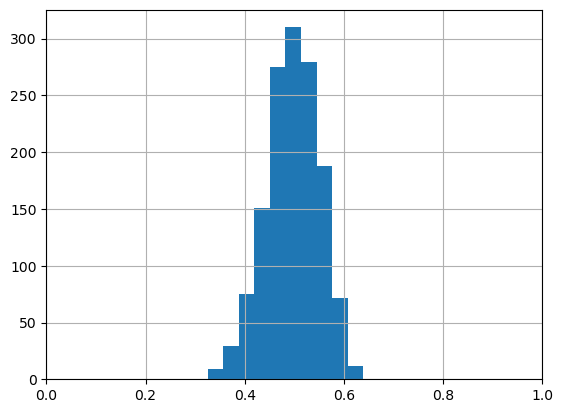

In [216]:
#checking overlap
df_paper_strata.pscore.hist().set_xlim(0,1)

df_paper_strata[['treatment','strata']].groupby('strata')

In [230]:
print(df_paper_strata[['paper_id','strata','treatment']].groupby(['strata','treatment']).count().to_latex())

\begin{tabular}{llr}
\toprule
  &   &  paper\_id \\
strata & treatment &           \\
\midrule
2 & 0 &        45 \\
  & 1 &         9 \\
3 & 0 &       851 \\
  & 1 &       472 \\
4 & 0 &        14 \\
  & 1 &         9 \\
\bottomrule
\end{tabular}



/var/folders/v9/8whxr3fd1mv_pwkjh0kn920m0000gn/T/ipykernel_6321/2705090609.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_paper_strata[['paper_id','strata','treatment']].groupby(['strata','treatment']).count().to_latex())


100%|████████████████████| 5000/5000 [00:07<00:00, 631.57it/s]

Bootstrap Naive ATE:  0.2583618208407602
95% confidence interval:  0.11853706465517644 0.3960481392501501
range of CI:  -0.27751107459497365


Text(0.5, 1.0, 'Check of Difference in Mean Distribution')

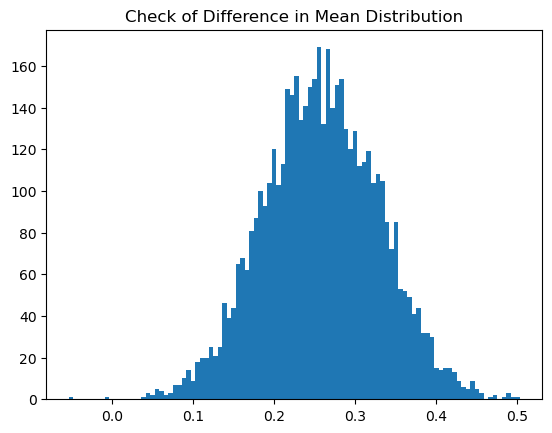

In [219]:
#2, 3, 4

boostrap_SPSM = []
for n in tqdm(range(5000)):
    sample = df_paper_strata.sample(n=df_paper_strata.shape[0], replace = True ,random_state=n)

    strata_2_weight = sample[sample['strata']==2].shape[0]/n_total

    strata_3_weight = sample[sample['strata']==3].shape[0]/n_total

    strata_4_weight = sample[sample['strata']==4].shape[0]/n_total

    strat_2_treated = sample[(sample['strata'] ==2) & (sample['treatment'] ==1)]['AVG_rating'].mean()
    strat_2_control = sample[(sample['strata'] ==2) & (sample['treatment'] ==0)]['AVG_rating'].mean()

    strat_3_treated = sample[(sample['strata'] ==3) & (sample['treatment'] ==1)]['AVG_rating'].mean()
    strat_3_control = sample[(sample['strata'] ==3) & (sample['treatment'] ==0)]['AVG_rating'].mean()

    strat_4_treated = sample[(sample['strata'] ==4) & (sample['treatment'] ==1)]['AVG_rating'].mean()
    strat_4_control = sample[(sample['strata'] ==4) & (sample['treatment'] ==0)]['AVG_rating'].mean()


    ATE = (strat_4_treated - strat_4_control)* strata_4_weight + (strat_3_treated - strat_3_control)* strata_3_weight + (strat_2_treated - strat_2_control)* strata_2_weight
    boostrap_SPSM.append(ATE)
    
SPSM_mean = statistics.mean(boostrap_SPSM)


print("Bootstrap Naive ATE: ", SPSM_mean)
print('95% confidence interval: ',np.quantile(boostrap_SPSM, 0.025),np.quantile(boostrap_SPSM, 0.975) )
print('range of CI: ',abs(np.quantile(boostrap_SPSM, 0.025)) -abs(np.quantile(boostrap_SPSM, 0.975)))
plt.hist(np.array(boostrap_SPSM), 100)
plt.title('Check of Difference in Mean Distribution')

In [220]:
df_paper_strata.to_csv('../../data/database/outputs/df_SPSM_results.csv', index = False)

In [261]:
df_paper_strata[(df_paper_strata['strata']==3) & 
                (df_paper_strata['transformed_keywords'].str.contains('deep_learning'))&
               (df_paper_strata['treatment']==1)].sample(n=1,random_state = 1).title.tolist()

['An Information-Theoretic Framework for Fast and Robust Unsupervised Learning via Neural Population Infomax']

In [262]:
df_paper_strata[(df_paper_strata['strata']==3) & 
                (df_paper_strata['transformed_keywords'].str.contains('deep_learning'))&
               (df_paper_strata['treatment']==0)].sample(n=10,random_state = 1).title.tolist()

['CAYLEYNETS: SPECTRAL GRAPH CNNS WITH COMPLEX RATIONAL FILTERS',
 'When is a Convolutional Filter Easy to Learn?',
 'Global Optimality Conditions for Deep Neural Networks',
 'A Deep Reinforced Model for Abstractive Summarization',
 'Deep Complex Networks',
 'Backpropagation through the Void: Optimizing control variates for black-box gradient estimation',
 'Adversarial Spheres',
 'Hierarchical Representations for Efficient Architecture Search',
 'Deep Temporal Clustering: Fully unsupervised learning of time-domain features',
 'Sparse Regularized Deep Neural Networks For Efficient Embedded Learning']

In [257]:
df_paper_strata[#(df_paper_strata['strata']==3) & 
                (df_paper_strata['transformed_keywords'].str.contains('deep_learning'))&
               (df_paper_strata['treatment']==1)].title.count()

311

In [258]:
df_paper_strata[#(df_paper_strata['strata']==3) & 
                (df_paper_strata['transformed_keywords'].str.contains('deep_learning'))&
               (df_paper_strata['treatment']==0)].title.count()

184